In [1]:
# import dependencies
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.models import load_model

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
import math
import shap

import os

In [2]:
# where to save the model output file
output_path = 'models/tubrofan_cnn.h5'

In [3]:
# load data
train_data = pd.read_csv('input/train_mm.csv')
test_data = pd.read_csv("input/test_mm.csv")
n_turb = train_data['id'].unique().max()

## 1 Preprocessing
Tensorflow NNs need a certain shape for the training data: (samples, time window, features)

In [4]:
# sensor selection based on Li2018
sensor_sel = ['s2','s3','s4','s7','s8','s9','s11','s12','s13','s14','s15','s17','s20','s21']

# time window size based on Li2018
time_window = 30

In [5]:
# function to reshape features into (samples, time steps, features) based on Vardoom2018
def reshapeFeatures(id_df, time_window, seq_cols):
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    for start, stop in zip(range(0, num_elements-time_window), range(time_window, num_elements)):
        yield data_matrix[start:stop, :]

In [6]:
# generator for the sequences
feat_gen = (list(reshapeFeatures(train_data[train_data['id']==id], time_window, sensor_sel)) 
           for id in range(1, n_turb + 1))

# generate sequences and convert to numpy array
train_array = np.concatenate(list(feat_gen)).astype(np.float32)

print("New shape of train_data: {} samples, {} cycles and {} features.".format(train_array.shape[0],
                                                                                  train_array.shape[1],
                                                                                  train_array.shape[2]))

New shape of train_data: 17631 samples, 30 cycles and 14 features.


Create labels for the train set based on the RUL values.

In [7]:
# function to generate labels based on Vardoom2018
def reshapeLabel(id_df, seq_length=time_window, label=['RUL']):
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    return data_matrix[seq_length: num_elements, :]

# generate labels
label_gen = [reshapeLabel(train_data[train_data['id']==id]) for id in range(1, n_turb + 1)]

label_array = np.concatenate(label_gen).astype(np.float32)

print(label_array.shape)

(17631, 1)


Create labels for the test set based on the RUL values.

In [8]:
# pick the last sequence for each id in the test data
seq_array_test_last = [test_data[test_data['id']==id][sensor_sel].values[-time_window:] 
                       for id in range(1, n_turb + 1) if len(test_data[test_data['id']==id]) >= time_window]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)

In [9]:
print("New shape of the test set: {} turbines, {} cycles and {} features.".format(
    seq_array_test_last.shape[0], seq_array_test_last.shape[1], seq_array_test_last.shape[2]))

New shape of the test set: 100 turbines, 30 cycles and 14 features.


In [10]:
y_mask = [len(test_data[test_data['id']==id]) >= time_window for id in test_data['id'].unique()]
label_array_test_last = test_data.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)

In [11]:
print(label_array_test_last.shape)

(100, 1)


## 2 Model Training

### Create the CNN model:

In [12]:
nb_features = train_array.shape[2]
nb_steps = train_array.shape[1]
nb_out = label_array.shape[1]

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
model = Sequential()
model.add(Conv1D(filters=10, kernel_size=1, activation='tanh', input_shape=(nb_steps, nb_features), dtype='float32'))
model.add(Conv1D(filters=10, kernel_size=1, activation='tanh'))
model.add(Conv1D(filters=10, kernel_size=1, activation='tanh'))
model.add(Conv1D(filters=10, kernel_size=1, activation='tanh'))
model.add(Conv1D(filters=10, kernel_size=1, activation='tanh'))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(units=100))
model.add(Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError(),'mae'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 30, 10)            150       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 30, 10)            110       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 30, 10)            110       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 30, 10)            110       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 30, 10)            110       
_________________________________________________________________
flatten (Flatten)            (None, 300)               0         
_________________________________________________________________
dropout (Dropout)            (None, 300)               0

In [13]:
start_time = time.time()

### Train the model:

In [14]:
epochs = 250
batch_size = 512

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 200.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lrate = LearningRateScheduler(step_decay)

# fit the network
history = model.fit(train_array, label_array, epochs=epochs, batch_size=batch_size, validation_split=0.05, verbose=1,
          callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=30,
                                                     verbose=0),
                       tf.keras.callbacks.ModelCheckpoint(output_path, monitor='val_loss',
                                                       save_best_only=True, mode='min', verbose=0),
                       lrate]
          )

Epoch 1/250
33/33 [==============================] - 2s 33ms/step - loss: 6498.8866 - root_mean_squared_error: 80.2269 - mae: 69.8208 - val_loss: 868.9711 - val_root_mean_squared_error: 29.4783 - val_mae: 25.5646
Epoch 2/250
33/33 [==============================] - 0s 7ms/step - loss: 899.8152 - root_mean_squared_error: 29.9876 - mae: 24.7287 - val_loss: 762.1370 - val_root_mean_squared_error: 27.6068 - val_mae: 24.1546
Epoch 3/250
33/33 [==============================] - 0s 7ms/step - loss: 730.1553 - root_mean_squared_error: 27.0208 - mae: 23.3144 - val_loss: 697.8243 - val_root_mean_squared_error: 26.4164 - val_mae: 22.6114
Epoch 4/250
33/33 [==============================] - 0s 7ms/step - loss: 670.6050 - root_mean_squared_error: 25.8953 - mae: 22.0597 - val_loss: 624.3569 - val_root_mean_squared_error: 24.9871 - val_mae: 21.2340
Epoch 5/250
33/33 [==============================] - 0s 7ms/step - loss: 628.0951 - root_mean_squared_error: 25.0613 - mae: 21.1061 - val_loss: 580.7516 -

Epoch 40/250
33/33 [==============================] - 0s 7ms/step - loss: 367.5677 - root_mean_squared_error: 19.1718 - mae: 15.3122 - val_loss: 267.7210 - val_root_mean_squared_error: 16.3622 - val_mae: 13.6690
Epoch 41/250
33/33 [==============================] - 0s 7ms/step - loss: 367.4795 - root_mean_squared_error: 19.1679 - mae: 15.2533 - val_loss: 274.4335 - val_root_mean_squared_error: 16.5660 - val_mae: 13.6716
Epoch 42/250
33/33 [==============================] - 0s 7ms/step - loss: 370.9917 - root_mean_squared_error: 19.2608 - mae: 15.3894 - val_loss: 267.5980 - val_root_mean_squared_error: 16.3584 - val_mae: 13.7814
Epoch 43/250
33/33 [==============================] - 0s 7ms/step - loss: 366.7702 - root_mean_squared_error: 19.1501 - mae: 15.4008 - val_loss: 277.5782 - val_root_mean_squared_error: 16.6607 - val_mae: 13.6829
Epoch 44/250
33/33 [==============================] - 0s 7ms/step - loss: 365.4912 - root_mean_squared_error: 19.1173 - mae: 15.2768 - val_loss: 275.826

Epoch 79/250
33/33 [==============================] - 0s 7ms/step - loss: 349.8918 - root_mean_squared_error: 18.7050 - mae: 14.9103 - val_loss: 276.4300 - val_root_mean_squared_error: 16.6262 - val_mae: 13.6284
Epoch 80/250
33/33 [==============================] - 0s 7ms/step - loss: 348.3520 - root_mean_squared_error: 18.6639 - mae: 14.9137 - val_loss: 259.8712 - val_root_mean_squared_error: 16.1205 - val_mae: 13.3409
Epoch 81/250
33/33 [==============================] - 0s 7ms/step - loss: 349.3943 - root_mean_squared_error: 18.6902 - mae: 14.8583 - val_loss: 283.4992 - val_root_mean_squared_error: 16.8374 - val_mae: 13.8151
Epoch 82/250
33/33 [==============================] - 0s 7ms/step - loss: 349.6904 - root_mean_squared_error: 18.6998 - mae: 14.8702 - val_loss: 275.7096 - val_root_mean_squared_error: 16.6045 - val_mae: 14.0446
Epoch 83/250
33/33 [==============================] - 0s 7ms/step - loss: 341.2952 - root_mean_squared_error: 18.4739 - mae: 14.7561 - val_loss: 281.878

In [15]:
print (time.time()-start_time)

27.020727396011353


In [16]:
print("Model saved as {}".format(output_path))

Model saved as models/tubrofan_cnn.h5


### Visualize the Learning History

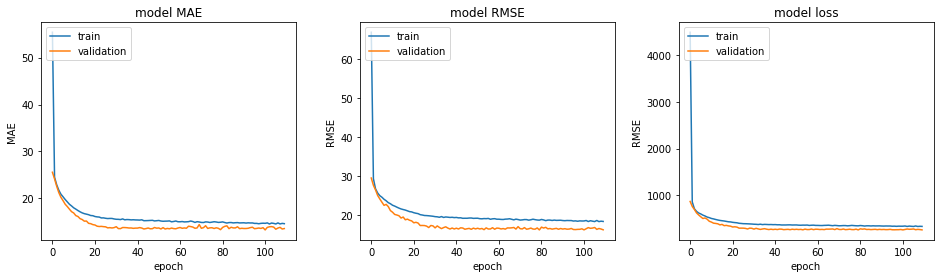

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

ax1.plot(history.history['mae'])
ax1.plot(history.history['val_mae'])
ax1.set(title="model MAE",xlabel='epoch', ylabel='MAE')
ax1.legend(['train', 'validation'], loc='upper left')

ax2.plot(history.history['root_mean_squared_error'])
ax2.plot(history.history['val_root_mean_squared_error'])
ax2.set(title="model RMSE",xlabel='epoch', ylabel='RMSE')
ax2.legend(['train', 'validation'], loc='upper left')

ax3.plot(history.history['loss'])
ax3.plot(history.history['val_loss'])
ax3.set(title="model loss",xlabel='epoch', ylabel='RMSE')
ax3.legend(['train', 'validation'], loc='upper left')

plt.subplots_adjust(wspace = 0.25)
plt.show()

## 3 Validation on the Test Data

In [18]:
if os.path.isfile(output_path):
    model = load_model(output_path, custom_objects={'root_mean_squared_error': "root_mean_squared_error"})
    
    t0 = time.time()
    y_pred_test = model.predict(seq_array_test_last)
    print("Prediction Time:",time.time()-t0)
    y_true_test = label_array_test_last
    
    # test metrics
    scores_test = model.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
    print('\nloss: {}'.format(scores_test[0]))
    print('\nRMSE: {}'.format(scores_test[1]))
    print('\nMAE: {}'.format(scores_test[2]))
    
    s1 = ((y_pred_test - y_true_test)**2).sum()
    moy = y_pred_test.mean()
    s2 = ((y_pred_test - moy)**2).sum()
    s = 1 - s1/s2
    print('\nEfficiency: {}%'.format(s * 100))

    test_set = pd.DataFrame(y_pred_test)
    test_set.to_csv('output/submit_test.csv', index = None)

Prediction Time: 0.10909914970397949
4/4 - 0s - loss: 217.4679 - root_mean_squared_error: 14.7468 - mae: 10.6535

loss: 217.46786499023438

RMSE: 14.74679183959961

MAE: 10.65350341796875

Efficiency: 85.78051030635834%


In [35]:
#results = pd.DataFrame(y_pred_test, columns=["predictions"])
#results["truth"] = y_true_test

In [39]:
#results["error"] = results["predictions"]- results["truth"]

In [40]:
#results

,predictions,truth,error
0,115.463745,112.0,3.463745
1,115.189049,98.0,17.189049
2,57.509705,69.0,-11.490295
3,87.201614,82.0,5.201614
4,101.026932,91.0,10.026932
...,...,...,...
95,113.746689,125.0,-11.253311
96,88.259949,82.0,6.259949
97,75.681389,59.0,16.681389
98,120.305733,117.0,3.305733
